# Topics – Easy Topic Modeling in Python

The text mining technique **Topic Modeling** has become a popular statistical method for clustering documents. This [Jupyter notebook](http://jupyter.org/) introduces a step-by-step workflow, basically containing data preprocessing, the actual topic modeling using **latent Dirichlet allocation** (LDA), which learns the relationships between words, topics, and documents, as well as some interactive visualizations to explore the model.

LDA, introduced in the context of text analysis in [2003](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), is an instance of a more general class of models called **mixed-membership models**. Involving a number of distributions and parameters, the topic model is typically performed using [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) with conjugate priors and is purely based on word frequencies.

There have been written numerous introductions to topic modeling for humanists (e.g. [this one](http://scottbot.net/topic-modeling-for-humanists-a-guided-tour/)), which provide another level of detail regarding its technical and epistemic properties.

For this workflow, you will need a corpus (a set of texts) as plain text (`.txt`) or [TEI XML](http://www.tei-c.org/index.xml) (`.xml`). Using the `dariah_topics` package, you also have the ability to process the output of [DARIAH-DKPro-Wrapper](https://github.com/DARIAH-DE/DARIAH-DKPro-Wrapper), a command-line tool for *natural language processing*.

Topic modeling works best with very large corpora. The [TextGrid Repository](https://textgridrep.org/) is a great place to start searching for text data. Anyway, to demonstrate the technique, we provide one small text collection in the folder `grenzboten_sample` containing 15 diary excerpts, as well as 15 war diary excerpts, which appeared in *Die Grenzboten*, a German newspaper of the late 19th and early 20th century.

**Of course, you can work with your own corpus in this notebook.**

We're relying on the LDA implementation by [Andrew McCallum](https://people.cs.umass.edu/~mccallum/), called [MALLET](http://mallet.cs.umass.edu/topics.php), which is known to be very robust. Aside from that, we provide two more Jupyter notebooks:

* [IntroducingMallet](IntroducingGensim.ipynb), using LDA by [Gensim](https://radimrehurek.com/project/gensim/), which is attractive because of its multi-core support.
* [IntroducingLda](IntroducingLda.ipynb), using LDA by [lda](http://pythonhosted.org/lda/index.html), which is very lightweight.

For more information in general, have a look at the [documentation](http://dev.digital-humanities.de/ci/job/DARIAH-Topics/doclinks/1/).

## First step: Installing dependencies

To work within this Jupyter notebook, you will have to import the `dariah_topics` library. As you do, `dariah_topics` also imports a couple of external libraries, which have to be installed first. `pip` is the preferred installer program in Python. Starting with Python 3.4, it is included by default with the Python binary installers. If you are interested in `pip`, have a look at [this website](https://docs.python.org/3/installing/index.html).

You have the ability to install dependencies via `pip` from within this notebook. To get a feeling for working with Jupyter, copy and paste (or best: type) the following code snippet in the empty cell below and press the **Run**-button.

```
import pip

pip.main(['install', '-r', 'requirements.txt'])
```

If you get any errors or are not able to install *all* dependencies properly, try [Stack Overflow](https://stackoverflow.com/questions/tagged/pip) for troubleshooting or create a new issue on our [GitHub page](https://github.com/DARIAH-DE/Topics).

**Furthermore**, you will have to install MALLET, or at least [download](http://mallet.cs.umass.edu/download.php), unzip and specifiy the path to the unzipped folder further below.

### What have I done?

With `import pip` you have imported the package `pip`, which is in the Python standard library included. In the next line, you called `pip`'s function `main` and commited a [list](https://en.wikipedia.org/wiki/List_(abstract_data_type) with three elements:

1. `install` is the command to install packages.
2. `-r` (or `--requirements`) installs from the given requirements file.
3. `requirements.txt` is a simple text file containing a list of all required libraries.

### Some final words
As you already know, code has to be written in the grey cells. You execute a cell by clicking the **Run**-button. If you want to run all cells of the notebook at once, click **Cell > Run All** or **Kernel > Restart & Run All** respectively, if you want to restart the Python kernel first. On the left side of an (unexecuted) cell stands `In [ ]:`. The empty bracket means, that the cell hasn't been executed yet. By clicking **Run**, a star appears in the brackets (`In [*]:`), which means the process is running. In most cases, you won't see that star, because your computer is faster than your eyes. You can execute only one cell at once, all following executions will be in the waiting line. If the process of a cell is done, a number appears in the brackets (`In [1]:`).

## Starting with topic modeling!

Execute the following cell to import modules from the `dariah_topics` library.

In [1]:
from dariah_topics import preprocessing
from dariah_topics import meta
from dariah_topics import mallet
from dariah_topics import postprocessing
from dariah_topics import visualization

ERROR visualization: WordCloud functions not available, they require the wordcloud module


Let's not pay heed to any warnings right now and execute the following cell.

In [2]:
import warnings
warnings.filterwarnings('ignore')

The following line will just tell the notebook to show graphics in the output frames.

In [3]:
%matplotlib inline

## 1. Preprocessing

### 1.1. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using the 30 diary excerpts from the folder `grenzboten`. To use your own corpus, change the path accordingly.

In [4]:
path_to_corpus = 'grenzboten_sample/*.txt'

By adding `/*.txt` to the actual path, we make sure to select only files with the suffix `.txt`.

#### Accessing file paths and metadata
We begin by creating a list of all the documents in the folder specified above. That list will tell the function `preprocessing.read_from_pathlist` (see below) which text documents to read. Furthermore, based on filenames we can create some metadata, e.g. author and title.

In [5]:
metadata = meta.fn2metadata(path_to_corpus)
metadata[:5] # by adding '[:5]' to the variable, only the first 5 elements will be printed

,author,basename,filename,title
0,Beck,Beck_1844_Tagebuch_56,grenzboten_sample/Beck_1844_Tagebuch_56.txt,1844_Tagebuch_56
1,Unbekannt,Unbekannt_1844_Tagebuch_70,grenzboten_sample/Unbekannt_1844_Tagebuch_70.txt,1844_Tagebuch_70
2,Nimmer,Nimmer_1844_Tagebuch_77,grenzboten_sample/Nimmer_1844_Tagebuch_77.txt,1844_Tagebuch_77
3,Unbekannt,Unbekannt_1844_Tagebuch_82,grenzboten_sample/Unbekannt_1844_Tagebuch_82.txt,1844_Tagebuch_82
4,Jörgel,Jörgel_1844_Tagebuch_88,grenzboten_sample/Jörgel_1844_Tagebuch_88.txt,1844_Tagebuch_88


#### Read listed documents from folder

In [6]:
corpus = list(preprocessing.read_from_pathlist(metadata['filename']))
corpus[0][:255] # printing the first 255 characters of the first document

'Tagebuch von Karl Beck. Man spricht seit vierzehn Tagen von einem vollständigen Ministerwechsel und es circuliren im Publicum die verschiedensten Combinationen, wobei heute ganz andere Namen genannt werden, als gestern und morgen wieder andere, als heute.'

Your `corpus` contains as much elements (`documents`) as texts in your corpus are. Each element of `corpus` is a list containing exactly one element, the text itself as one single string including all whitespaces and punctuations:

```
[['This is the content of your first document.'],
 ['This is the content of your second document.'],
 ...
 ['This is the content of your last document.']]
```

### 1.3. Tokenize corpus
Now, your `documents` in `corpus` will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function `dariah_topics` provides is a simple Unicode tokenizer. Depending on the corpus, it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [7]:
tokenized_corpus = [list(preprocessing.tokenize(document)) for document in corpus]

At this point, each `document` is represented by a list of separate token strings. As above, have a look at the first document (which has the index `0` as Python starts counting at 0) and show its first 14 words/tokens (that have the indices `0:13` accordingly).

In [8]:
tokenized_corpus[0][0:13]

['tagebuch',
 'von',
 'karl',
 'beck',
 'man',
 'spricht',
 'seit',
 'vierzehn',
 'tagen',
 'von',
 'einem',
 'vollständigen',
 'ministerwechsel']

### 1.4.1 Create a document-term matrix

The LDA topic model is based on a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) of the corpus. To improve performance in large corpora, the matrix describes the frequency of terms that occur in the collection. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

In [9]:
document_term_matrix = preprocessing.create_document_term_matrix(tokenized_corpus, metadata['title'])
document_term_matrix[:5]

,die,der,und,in,den,von,zu,das,des,nicht,...,staatsmonopol,steigernde,staatspapieren,staatsrücksichten,staatszeitung,stallknecht,stammen,starkem,statu,subscriben
1844_Tagebuch_56,90.0,92.0,84.0,70.0,30.0,26.0,25.0,16.0,25.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_70,205.0,224.0,193.0,133.0,78.0,64.0,112.0,86.0,45.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_77,181.0,153.0,141.0,98.0,55.0,59.0,72.0,59.0,44.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_82,213.0,207.0,169.0,128.0,85.0,86.0,79.0,80.0,66.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_88,68.0,59.0,70.0,54.0,22.0,27.0,28.0,19.0,13.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5. Feature removal

*Stopwords* (also known as *most frequent tokens*) and *hapax legomena* are harmful for LDA and have to be removed from the corpus or the document-term matrix respectively. In this example, the 50 most frequent tokens will be categorized as stopwords.

**Hint**: Be careful with removing most frequent tokens, you might remove tokens quite important for LDA. Anyway, to gain better results, it is highly recommended to use an external stopwords list.

In this notebook, we combine the 50 most frequent tokens, hapax legomena and an external stopwordslist.

#### List the 100 most frequent words

In [10]:
stopwords = preprocessing.find_stopwords(document_term_matrix, most_frequent_tokens=100)

These are the five most frequent words:

In [11]:
stopwords[:5]

['die', 'der', 'und', 'in', 'den']

#### List hapax legomena

In [12]:
hapax_legomena = preprocessing.find_hapax_legomena(document_term_matrix)
print("Total number of types in corpus:", document_term_matrix.shape[1])
print("Total number of hapax legomena:", len(hapax_legomena))

Total number of types in corpus: 24451
Total number of hapax legomena: 19757


#### Optional: Use external stopwordlist

In [13]:
path_to_stopwordlist = "tutorial_supplementals/stopwords/de.txt"
external_stopwords = [line.strip() for line in open(path_to_stopwordlist, 'r', encoding='utf-8')]

#### Combine lists and remove content from `doc_term_matrix`

In [14]:
features = stopwords + hapax_legomena + external_stopwords
document_term_matrix = preprocessing.remove_features(features, document_term_matrix=document_term_matrix)

Finally, this is how your clean corpus looks like now.

In [15]:
document_term_matrix[:5]

,franzosen,genommen,abgewiesen,südlich,berlin,lassen,geschütze,englische,januar,deutschland,...,bankprojects,ii&gt,pflanzenausstellung,unbekümmert,nischt,thiaumont-walde,kompositionen,monarchischer,ehrenwerthen,zaturcy
1844_Tagebuch_56,0.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_70,2.0,1.0,0.0,0.0,8.0,6.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_77,0.0,1.0,0.0,0.0,5.0,9.0,0.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_82,0.0,0.0,0.0,0.0,5.0,10.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_88,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Write MALLET import files

In [16]:
postprocessing.save_tokenized_corpus(tokenized_corpus, metadata['basename'], 'tutorial_supplementals/mallet_input')

## 1. Setting the parameters

#### Define path to corpus folder

In [17]:
path_to_corpus = 'tutorial_supplementals/mallet_input'

#### Path to mallet folder 

Now we must tell the library where to find the local instance of mallet. If you managed to install Mallet, it is sufficient set `path_to_mallet = "mallet"`, if you just store Mallet in a local folder, you have to specify the path to the binary explictly.

In [18]:
path_to_mallet = 'mallet'

#### Output folder

In [19]:
output_folder = 'tutorial_supplementals/mallet_output'
mallet_binary = 'tutorial_supplementals/mallet_output/binary.mallet'

#### The Mallet corpus model

Finally, we can give all these folder paths to a Mallet function that handles all the preprocessing steps and creates a Mallet-specific corpus model object.

In [20]:
%%time

mallet_binary = mallet.create_mallet_binary(path_to_mallet=path_to_mallet,
                                            path_to_corpus=path_to_corpus,
                                            output_file=mallet_binary) 

CPU times: user 4.29 ms, sys: 4.47 ms, total: 8.77 ms
Wall time: 212 ms


## 2. Model creation

We use the function `create_mallet_model()` from the library `dariah_topics.mallet` to generate a LDA topic model. To create a LDA model, there have to be specified a couple of parameters.

But first, if you are curious about any library, module, class or function, try `help()`. This can be very useful, because (at least in a well documented library) explanations of use and parameters will be printed. We're interested in the function `create_mallet_model()` in the module `dariah_topics.mallet`, so let's try:

```
help(mallet.create_mallet_model)
```

This will print something like this (in fact even more):

```
Help on function create_mallet_model in module dariah_topics.mallet:

create_mallet_model(parameter ...)
    Args:
        path_to_mallet (str): Path to MALLET. Defaults to 'mallet'. If MALLET is
            not properly installed use absolute path, e.g. '/home/workspace/mallet/bin/mallet'.
        path_to_binary (str): Path to previously created MALLET binary.
        input_model (str): Absolute path to the binary topic model created by `output_model`.
        input_state (str): Absolute path to the gzipped Gibbs sampling state created by `output_state`.
        folder_for_output (str): Folder for MALLET output.
        output_model (bool): Write a serialized MALLET topic trainer object.
            This type of output is appropriate for pausing and restarting training,
            but does not produce data that can easily be analyzed. Defaults to True.
        output_topic_keys (bool): Write the top words for each topic and any
            Dirichlet parameters. Defaults to True.
        topic_word_weights_file (bool): Write unnormalized weights for every
            topic and word type. Defaults to True.
        word_topic_counts_file (bool): Write a sparse representation of topic-word
            assignments. By default this is null, indicating that no file will
            be written. Defaults to True.
        output_doc_topics (bool): Write the topic proportions per document, at
            the end of the iterations. Defaults to True.
        doc_topics_threshold (float): Do not print topics with proportions less
            than this threshold value within `output_doc_topics`. Defaults to 0.0.
        num_topics (int): Number of topics. Defaults to 10.
        num_top_words (int): Number of keywords for each topic. Defaults to 10.
        num_interations (int): Number of iterations. Defaults to 1000.
        num_threads (int): Number of threads for parallel training.  Defaults to 1.
        num_icm_iterations (int): Number of iterations of iterated conditional
            modes (topic maximization).  Defaults to 0.
        alpha (float): Sum over topics of smoothing over doc-topic distributions.
            alpha_k = [this value] / [num topics]. Defaults to 5.0.
        beta (float): Smoothing parameter for each topic-word. Defaults to 0.01
```

So, now you know how to define the number of topics and the number of sampling iterations as well. A higher number of iterations will probably yield a better model, but also increases processing time. `alpha` and `beta` are so-called *hyperparameters*. They influence the model's performance, so feel free to play around with them. In the present example, we will leave the default values. Furthermore, there exist various methods for hyperparameter optimization, e.g. gridsearch or Gaussian optimization.

**Warning: This step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of iterations. Our example corpus should be done within a minute or two at `num_iterations=5000`.

In [21]:
%%time

mallet.create_mallet_model(path_to_mallet=path_to_mallet, 
                           path_to_binary=mallet_binary, 
                           folder_for_output=output_folder,
                           num_iterations=5000,
                           num_topics=10)

CPU times: user 3.86 ms, sys: 4.43 ms, total: 8.29 ms
Wall time: 194 ms


### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas data frame) that constitutes our principle exchange format for topic modeling results. For generating the matrix from a Gensim model, we can use the following function:

In [22]:
topics = postprocessing.show_topics(topic_keys_file='tutorial_supplementals/mallet_output/topic_keys.txt')
topics

,Key 0,Key 1,Key 2,Key 3,Key 4,Key 5,Key 6,Key 7,Key 8,Key 9
Topic 0,drei,september,deutscher,england,wegen,paris,regierung,deutschland,gebracht,machen
Topic 1,leben,deutschland,kunst,erste,könig,geschichte,professor,verfasser,ganze,kam
Topic 2,vom,einmal,wiener,waren,berliner,zwei,steht,allgemeinen,schreiben,eben
Topic 3,leipzig,ward,stadt,mag,herrn,darauf,möglich,sieht,theil,sollte
Topic 4,scheint,presse,werde,sei,irgend,dadurch,frage,eigentlich,vom,briefe
Topic 5,geschütze,januar,abgewiesen,genommen,östlich,kriegstagebuch,franzosen,angriff,engländer,truppen
Topic 6,ohne,seinen,wohl,dieses,diesem,hatte,lassen,muß,ihren,unserer
Topic 7,ihr,immer,ganz,nun,sondern,ihn,nichts,wurde,keine,weil
Topic 8,ihnen,ihrer,worden,diesen,damit,halten,wurden,frankreich,menschen,französischen
Topic 9,südlich,juli,märz,april,zwischen,stellungen,abgewiesen,nördlich,heftige,gestürmt


## 3. Visualization

Now we can see the topics in the model with the following function:

**Hint:** Depending on the number of topics chosen in step 2, you might have to adjust *num_topics* in this step accordingly.

In [23]:
document_topics = postprocessing.show_document_topics(topics=topics,
                                                      doc_topics_file='tutorial_supplementals/mallet_output/doc_topics.txt')
document_topics[:5]

,drei september deutscher,leben deutschland kunst,vom einmal wiener,leipzig ward stadt,scheint presse werde,geschütze januar abgewiesen,ohne seinen wohl,ihr immer ganz,ihnen ihrer worden,südlich juli märz
Grenzboten_1844_Tagebuch_56.txt,0.069915,0.058898,0.137712,0.105508,0.041949,0.012288,0.218220,0.308051,0.047034,0.000424
Grenzboten_1844_Tagebuch_70.txt,0.053368,0.069603,0.274093,0.043005,0.066149,0.003282,0.178411,0.260622,0.050604,0.000864
Grenzboten_1844_Tagebuch_77.txt,0.047408,0.089128,0.143911,0.159503,0.032659,0.000632,0.244627,0.209650,0.072271,0.000211
Grenzboten_1844_Tagebuch_82.txt,0.046118,0.049323,0.099893,0.185363,0.080662,0.004452,0.248397,0.224537,0.060007,0.001246
Grenzboten_1844_Tagebuch_88.txt,0.059833,0.079314,0.350186,0.064471,0.057978,0.000464,0.108071,0.182282,0.093228,0.004174


### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in a heat map.

In [24]:
from bokeh.io import show

plot = visualization.doc_topic_heatmap_interactive(document_topics, title='Grenzboten')
show(plot, notebook_handle=True)

Loading BokehJS ...

#### Distribution of topics in a single documents

To take closer look on the topics in a single text, we can use the follwing function that shows all the topics in a text and their respective proportions. To select the document, we have to give its index to the function.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

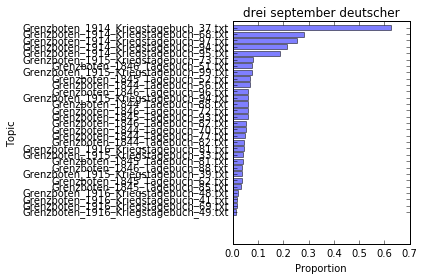

In [25]:
visualization.plot_doc_topics(document_topics, 0)